In [ ]:
# Google Colab
from google.colab import drive
%tensorflow_version 2.x

# System
import sys
import os
import time

# DS python libraries and framework
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf

print("Python version :",sys.version)
print("TensorFlow version :",tf.version.VERSION)

# execution device management
devices = tf.config.list_physical_devices()
print(f"\n>> Available devices:\n {devices}")
# beginning /physical_device  is subtracted
GPU, CPU, BESTDEV = None, None, None
for dev in devices:
    if dev.device_type == 'GPU':
            tokens = dev.name.split(':')[-2:]
            name = ':'.join(tokens)
            GPU = '/device:' + name
            print(f"GPU device found: '{GPU}'")
            BESTDEV = GPU
    elif dev.device_type == 'CPU':
            name = dev.name
            tokens = dev.name.split(':')[-2:]
            name = ':'.join(tokens)
            CPU = '/device:' + name
            print(f"CPU device found: '{CPU}'")
if not GPU:
    print("GPU device NOT found")
    BESTDEV = CPU
print(f"Best device is: '{BESTDEV}'")


from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Embedding,GRU,MaxPooling1D,GlobalMaxPooling1D,BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier


import matplotlib.pyplot as plt
from matplotlib import cm

import itertools

#mount Google drive
print("Google drive :")
drive.mount("/content/drive",force_remount=True)
PATH_WORK = "/content/drive/MyDrive/Rakuten"

#go to working directory
os.chdir(PATH_WORK)
print("content of CWD :",os.listdir())

data_train = pd.read_csv('X_train_rakuten_afterEDA_preprocessing.csv',index_col=0)
data_train = data_train.reset_index(drop=False)
data_train['nom_img'] = r"/tmp/images/cropped_image_train/" + data_train['nom_img']
data_train.shape

Python version : 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
TensorFlow version : 2.7.0

>> Available devices:
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CPU device found: '/device:CPU:0'
GPU device found: '/device:GPU:0'
Best device is: '/device:GPU:0'
Google drive :
Mounted at /content/drive
content of CWD : ['X_train_rakuten_afterEDA_preprocessing.csv', 'cropped_image_train.zip', 'Rakuten_multimodal_Xception_embedding-GRU.h5', 'model.png', 'Rakuten_multimodal_best_model_8409_pretrained_VGG16_embedding-GRU.h5', 'df_train_ready_for_TFCamembertModel.csv', 'df_test_ready_for_TFCamembertModel.csv']


(84613, 6)

# **install sentencepiece package<br>and download transformers from huggingface github**


In [ ]:
%%bash
pip install sentencepiece
pip install git+https://github.com/huggingface/transformers


  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-kd1uncu2
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for transformers: filename=transformers-4.13.0.dev0-py3-none-any.whl size=3128239 sha256=a70037a46d877c2d4c00e606d41fd4c2c5e6d23cfde9088a5cf5572bfd21e2fa
  Stored in directory: /tmp/pip-ephem-wheel-cache-wdm3d098/wheels/35/2e/a7/d819e3310040329f0f47e57c9e3e7a7338aa5e74c49acfe522
Successfully built transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-kd1uncu2


# **import Camembert model for tensorflow framework,<br> its tokenizer and weights of camembert-base file**

In [ ]:
import transformers
from transformers import TFCamembertModel, CamembertTokenizerFast, CamembertConfig
print("transformers package version :",transformers.__version__)
# Load pretrained model/tokenizer and its weights
tokenizer = CamembertTokenizerFast.from_pretrained("camembert-base")
print(tokenizer)
#config = CamembertConfig.from_pretrained("camembert-base", output_hidden_states=True)
camembert = TFCamembertModel.from_pretrained("camembert-base")

transformers package version : 4.13.0.dev0


Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

PreTrainedTokenizerFast(name_or_path='camembert-base', vocab_size=32005, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False), 'additional_special_tokens': ['<s>NOTUSED', '</s>NOTUSED']})


Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

Some layers from the model checkpoint at camembert-base were not used when initializing TFCamembertModel: ['lm_head']
- This IS expected if you are initializing TFCamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFCamembertModel were not initialized from the model checkpoint at camembert-base and are newly initialized: ['roberta/pooler/dense/bias:0', 'roberta/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#display columns including product images (nom_img)
data_train.head()

,designation_orig,nom_img,lang_designation,designation,prdtypecode,designation_token_final
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,/tmp/images/cropped_image_train/image_12635970...,de,olivia: notebook personnalise / pages / punks...,10,"['notebook', 'page', 'design']"
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,/tmp/images/cropped_image_train/image_10081412...,fr,journal des art (le) n° du // art et son ma...,2280,"['journal', 'art', 'art', 'marche', 'salon', '..."
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,/tmp/images/cropped_image_train/image_93877797...,fr,grand stylet ergonomique bleu gamepad nintendo...,50,"['stylet', 'ergonomique', 'gamepad', 'nintendo..."
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,/tmp/images/cropped_image_train/image_45704749...,fr,peluche donald europe disneyland (marionn...,1280,"['peluche', 'donald', 'europe', 'disneyland', ..."
4,La Guerre Des Tuques Luc a des idées de grande...,/tmp/images/cropped_image_train/image_10777577...,fr,la guerre des tuques luc a des idees de grande...,2705,"['guerre', 'luc', 'idees', 'grandeur', 'vouloi..."


In [ ]:
#in case file not found error in the cell that checks image file size null or smaller than 2Kb to clean rows of dataset
#%%bash
#rm -rf /tmp/images

In [ ]:
%%bash

# Images source and destination
SRC="/content/drive/MyDrive/Rakuten/cropped_image_train.zip"
DEST="/tmp/images"


# Check it has not been done
if [ -d "$DEST" ]; then
    echo "Images already unzipped"
else
    # Create directory and unzip all set of images
    mkdir -p "$DEST"
    unzip -q "$SRC" -d "$DEST"
    echo "Images unzipped"
fi

Images unzipped


In [ ]:
#delete rows where images are smaller than 2k equal to noise rather than information
from pathlib import Path

list_products_to_be_deleted_due_to_too_small_image = []
nbr_to_be_deleted = 0
for i in range(len(data_train)):
    fname = data_train['nom_img'].iloc[i]
    file_size =Path(fname).stat().st_size
    if (file_size < 2048):
        #print("The file {0} has a too small size of {1} bytes ".format(fname,file_size))
        list_products_to_be_deleted_due_to_too_small_image.append(i)
        nbr_to_be_deleted += 1

#rows deletion
print("number of deleted rows due to image size smaller than 2K :",nbr_to_be_deleted)
print(data_train.shape)
data_train = data_train.drop(list_products_to_be_deleted_due_to_too_small_image)
print("new shape of dataset after preprocessing : ", data_train.shape)

number of deleted rows due to image size smaller than 2K : 237
(84613, 6)
new shape of dataset after preprocessing :  (84376, 6)


In [ ]:
#cell specific for text preprocessing handled by Neural Network
# column designation_token_final is the result of preprocessing text cleaning (stopwords and so on) under tokens form
# so, we transform it again into text string in designation_str_tokens that is now the features data column
# to prepare the association between each word and a integer number (index in dictionary of full vocabulary describing products)
import re
data_train['designation_str_tokens'] = ""
for i in range(len(data_train)):
    data_train['designation_str_tokens'].iloc[i] += "".join(data_train['designation_token_final'].iloc[i]) 

data_train['designation_str_tokens'] = data_train['designation_str_tokens'].map(lambda x: re.sub(r',', '', x))
data_train['designation_str_tokens'] = data_train['designation_str_tokens'].map(lambda x: re.sub(r"'", '', x))
data_train['designation_str_tokens'] = data_train['designation_str_tokens'].map(lambda x: re.sub(r'\[', '', x))
data_train['designation_str_tokens'] = data_train['designation_str_tokens'].map(lambda x: re.sub(r'\]', '', x))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
#training and validation set , not yet test set 
target = data_train.prdtypecode
data_train = data_train.drop(['designation_orig','lang_designation','designation','designation_token_final'],axis=1)

#Divide randomly data into training and validation set
#for image and text handled by DL
#X_train, X_test, y_train, y_test = train_test_split(data_train,target, test_size=0.2, random_state=42)

#for text handled by ML algorithms
#X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, target , test_size=0.2,random_state=42)


name_class = ['editions','magazines',"equipement_playstation","jouets_enfant","livres","fournitures_scolaires","materiel_jardin","mobilier_interieur","jeux_enfants","literie","livres_par_lot","figurine","materiel_piscine","univers_de_fiction","equipements_telecommandes","materiel_jeux_video","jeux_de_cartes_collection","decoration","jeux_video","console_de_jeu","materiel_bebe","peche_lampe_plein_air","materiel_animaux_compagnie","jeux_sur_PC","accessoires_outil","articles_nourriture","vetements_nouveau-né_et_billard_flechettes"] 
list_class = [10, 2280 ,  50 ,1280 ,2705, 2522, 2582, 1560, 1281, 1920, 2403, 1140, 2583, 1180, 1300 ,2462, 1160, 2060 , 40,   60 ,1320 ,1302 ,2220 ,2905, 2585, 1940 ,1301]       
list_class_onehot = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

# df_train and df_test will be used to build the batchs !!!!!!
data_train['class_onehot']= 0
for i in range(len(data_train)):
    index = list_class.index(data_train['prdtypecode'].iloc[i])
    data_train['class_onehot'].iloc[i] = list_class_onehot[index]

display(data_train.head(25))



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,nom_img,prdtypecode,designation_str_tokens,class_onehot
0,/tmp/images/cropped_image_train/image_12635970...,10,notebook page design,0
1,/tmp/images/cropped_image_train/image_10081412...,2280,journal art art marche salon art asiatique par...,1
2,/tmp/images/cropped_image_train/image_93877797...,50,stylet ergonomique gamepad nintendo wii speedl...,2
3,/tmp/images/cropped_image_train/image_45704749...,1280,peluche donald europe disneyland marionnette d...,3
4,/tmp/images/cropped_image_train/image_10777577...,2705,guerre luc idees grandeur vouloir organiser je...,4
5,/tmp/images/cropped_image_train/image_39335683...,2280,afriqu contemporain hiver dossier japon afrique,1
6,/tmp/images/cropped_image_train/image_90779453...,10,processus educatif sentier,0
7,/tmp/images/cropped_image_train/image_99958134...,2522,conquerer sept cahier couverture polypro page ...,5
8,/tmp/images/cropped_image_train/image_13259188...,1280,puzzle poster,3
9,/tmp/images/cropped_image_train/image_12456441...,2582,tente pliant pro pvc tente pliant pro pvc m.qu...,6


# **convert words into integer numbers using specific tokenizer of camembert model<br> and force the max length of 512 as expected by model<br> (truncating or padding if necessary)**

In [ ]:
#tokenise the product designation string and convert it in TF tensor for TFCamembertModel
tokenized = data_train['designation_str_tokens'].apply((lambda x: tokenizer.encode(x, add_special_tokens = True , padding = "max_length", truncation = True, max_length=512)))


# **attention_mask if very important because it indicates to the model the meaningfull integer numbers corresponding to converted words**

In [ ]:
array_tokenized = np.array([i for i in tokenized.values]).astype('int32')
print(array_tokenized.shape)
print("token ids of first array partially displayed :")
print(array_tokenized[0][:50])
attention_mask = np.where(array_tokenized != 1, 1, 0).astype('int32')
print("mask given to camemBERT to indicate padding :")
print(attention_mask.shape)
print(attention_mask[0][:50])

(84376, 512)
token ids of first array partially displayed :
[   5 1683 6780  563 1160    6    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1]
mask given to camemBERT to indicate padding :
(84376, 512)
[1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


**Here, only one array element ( shape (1,512) ) is put in the input tensor of the model.<br>The model output is last_hidden_state tensor in which we extract only the position 0 of 512<br> (0 before :) related to CLS tag as it is a classification use-case.<br>The : represents the vector of 768 floats (size of hidden_size)**

In [ ]:
start = time.time()
features = np.zeros(shape=(84376,768))
for i in range(len(data_train)):
  #shape of tensor (1,512)
  tf_input_ids = tf.convert_to_tensor(array_tokenized[i:i+1])
  tf_attention_mask = tf.convert_to_tensor(attention_mask[i:i+1])
  last_hidden_state = camembert(tf_input_ids,tf_attention_mask)
  #print(last_hidden_state[0][0,0,:])
  features[i] = last_hidden_state[0][0,0,:].numpy()
end = time.time()
elapsed = end - start
print(f'Temps d\'exécution : {elapsed:.2f} s')

Temps d'exécution : 10854.90 s


# **Now, that the features step is done (embeddings produced by TFCamembertModel)<br>split the data into a train_set and a test_set<br> to train and evaluate the upcoming classifier**

In [ ]:

labels = data_train['class_onehot']
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)
print("size of train set :",train_features.shape())
print("size of test set :",test_features.shape())

size of train set : [[ 0.03298355  0.06303185  0.00647193 ... -0.039093   -0.01656656
   0.01604255]
 [ 0.00265963  0.03102968  0.03518056 ... -0.04913015  0.01172845
   0.06915306]
 [-0.03826575  0.22783919  0.09132211 ... -0.17202564  0.06231961
  -0.03205033]
 ...
 [ 0.01885233  0.08715148  0.13541178 ... -0.05101515 -0.00314936
  -0.06150584]
 [ 0.01115659  0.1597859   0.09352835 ... -0.07911932 -0.01402605
  -0.05332173]
 [-0.01412555  0.24990551  0.13090511 ... -0.12062782  0.04039468
  -0.12491979]]
size of test set : [[-0.0486671   0.07248101  0.05758449 ... -0.17867467 -0.02924015
   0.02092969]
 [-0.01681869  0.14153604  0.06268299 ... -0.15517767  0.03797789
  -0.04269478]
 [ 0.01818363  0.19463542  0.05214331 ... -0.08227308 -0.11638358
  -0.00647082]
 ...
 [-0.04246814  0.14578512 -0.03930174 ... -0.0631022   0.06031926
  -0.00046573]
 [-0.00802325  0.09895151  0.04548101 ... -0.07727297 -0.07664257
   0.06245444]
 [-0.00663978  0.07622392  0.00273615 ... -0.15815498  0.06

# **SVC classifier training<br> and both predictions type outputs :<br> one class and probability between the 27 classes** 

In [ ]:
# MODEL  : Support Vectors Classifier
#Classifier instanciation
clf2 = SVC(probability=True)

# Training and prediction
start = time.time()
clf2.fit(train_features,train_labels)
y_pred_clf2 = clf2.predict(test_features)
y_pred_proba_clf2 = clf2.predict_proba(test_features)

end = time.time()
elapsed = end - start
print(f'Temps d\'exécution : {elapsed:.2f} s')

Temps d'exécution : 11824.02 s


# **SVC evaluation using both classification_report and confusion matrix**

              precision    recall  f1-score   support

           0       0.39      0.57      0.46       631
           1       0.58      0.71      0.64       948
           2       0.77      0.69      0.73       335
           3       0.59      0.56      0.57       969
           4       0.97      0.60      0.74       521
           5       0.80      0.86      0.83      1020
           6       0.71      0.54      0.61       508
           7       0.69      0.75      0.72      1007
           8       0.72      0.41      0.52       396
           9       0.86      0.88      0.87       869
          10       0.68      0.63      0.65       963
          11       0.61      0.65      0.63       515
          12       0.91      0.95      0.93      2047
          13       0.92      0.20      0.33       169
          14       0.75      0.90      0.82       995
          15       0.67      0.69      0.68       294
          16       0.60      0.83      0.69       771
          17       0.72    

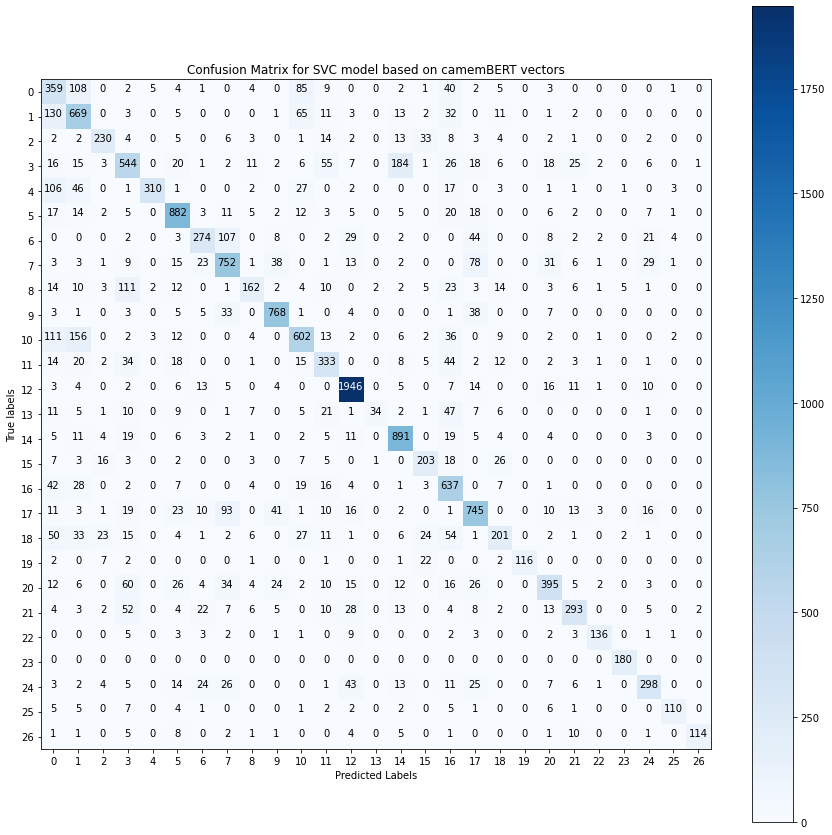

In [ ]:
# SVC model evaluation

# Classification Report
print(classification_report(test_labels, y_pred_clf2))

# Confusion matrix
#pd.crosstab(test_labels, y_pred_clf2, rownames=['classes réelles'], colnames=['classes prédites'])
import itertools # To create iterators

cnf_matrix = metrics.confusion_matrix(test_labels, y_pred_clf2)

classes = range(0,27)

plt.figure(figsize = (15,15))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Confusion Matrix for SVC model based on camemBERT vectors")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)


for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Predicted Labels')
plt.show()

**save of classifier model on disk for further use**

In [ ]:
# operational model but not better than SVC based on embedding tfidf
import joblib

# save the model to disk
filename = 'embedding_camemBERT_classifier_SVC_finalized_model_by_joblib.sav'
joblib.dump(clf2, filename)

['embedding_camemBERT_classifier_SVC_finalized_model_by_joblib.sav']